In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Configuración de logging para Prophet
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled = True


from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [128]:
# Definir la lista de tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']

# Función para preparar los datos para un ticker específico
def prepare_data_for_ticker(df, ticker):
    ts_tools = tools()
    df_ticker = df[df['ticker'] == ticker].copy()
    df_ticker = ts_tools.ts_prepartion(df_ticker, 'Date', 'Adj Close')
    df_ticker['y'] = df_ticker['y'].interpolate(method='linear')
    df_ticker = df_ticker.iloc[::-1].reset_index(drop=True)
    return df_ticker

# Descargar datos para todos los tickers
loader = LoadingData(tickers=tickers)
Y_df = loader.get_data(start_date='2019-01-01', end_date='2023-12-31', interval='1d')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

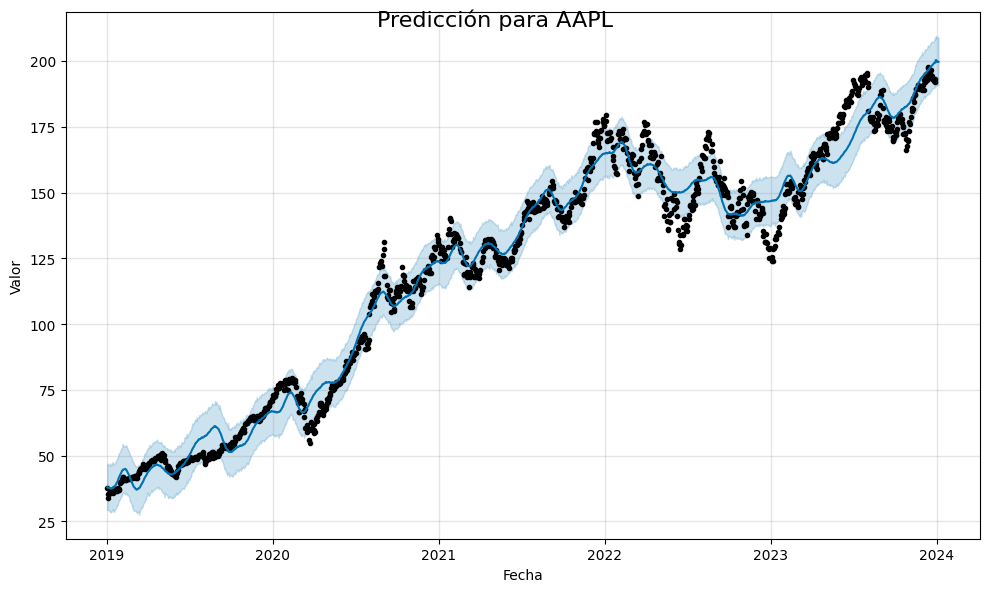

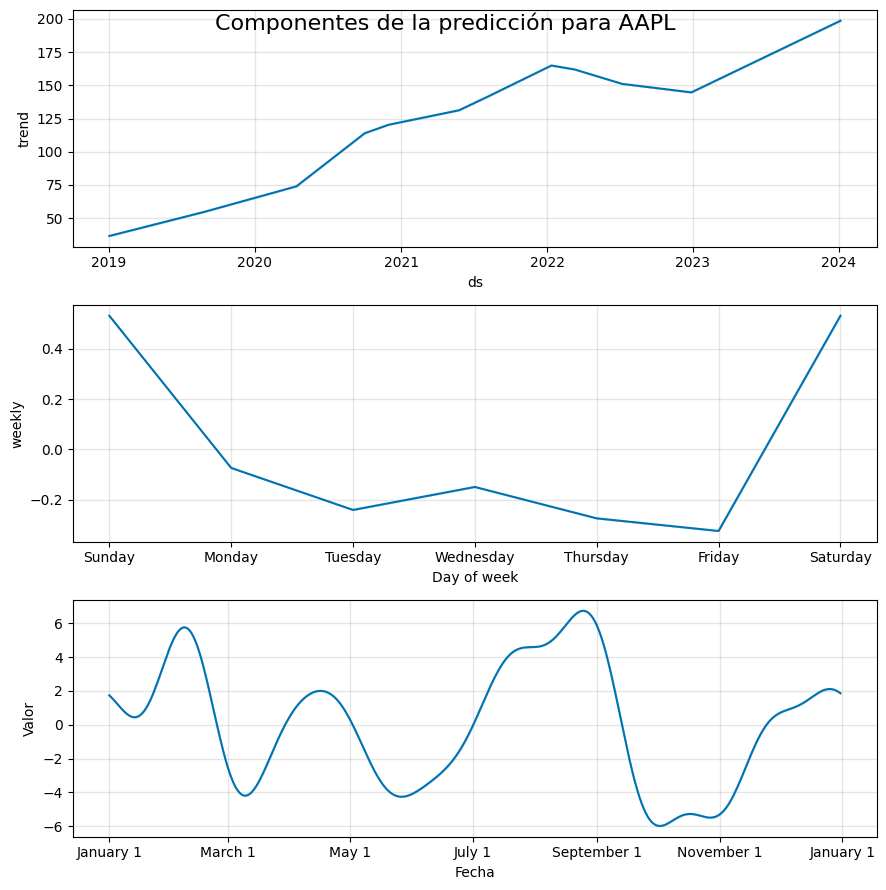

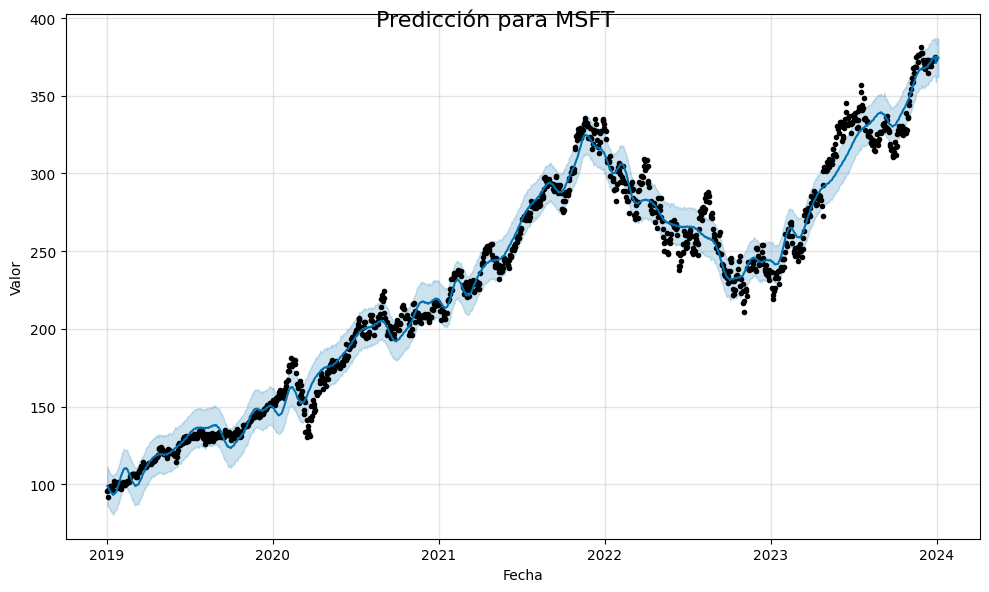

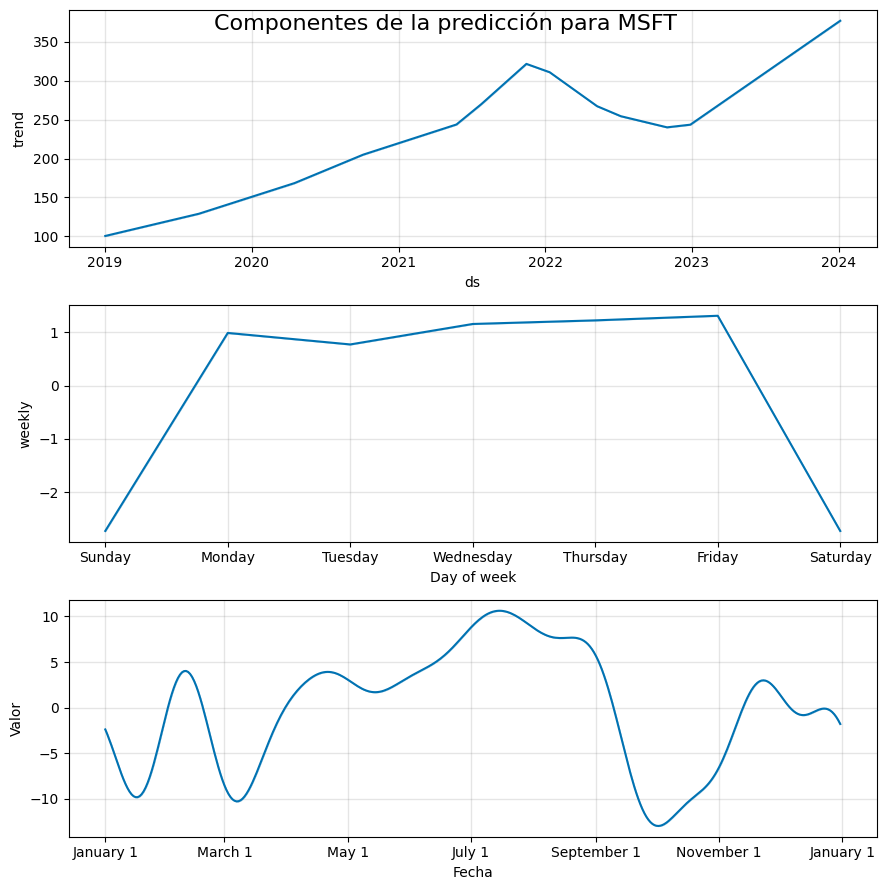

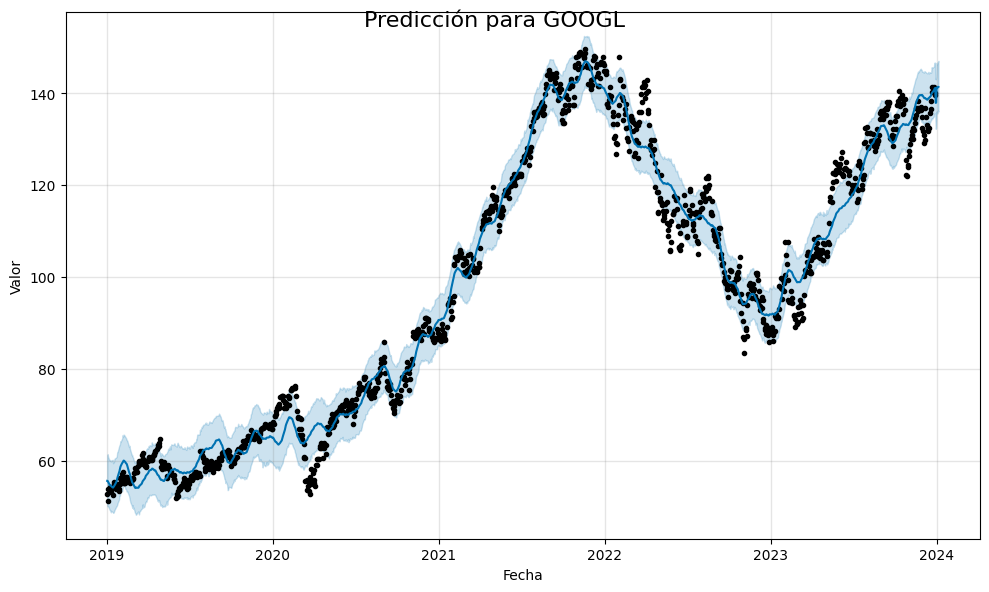

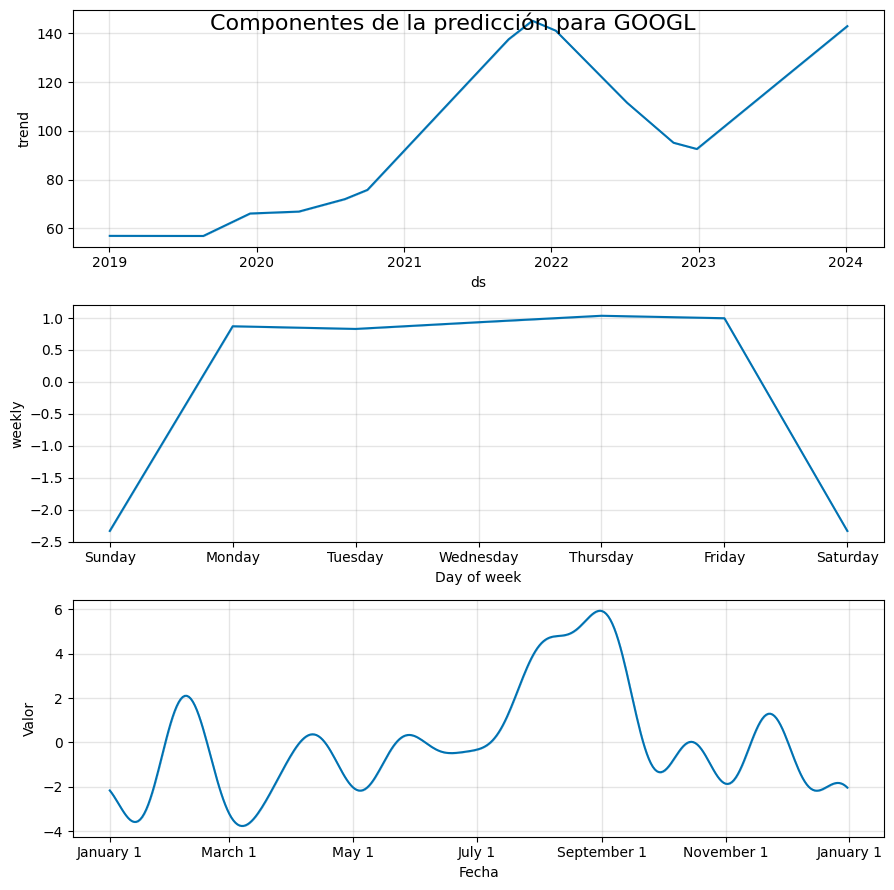

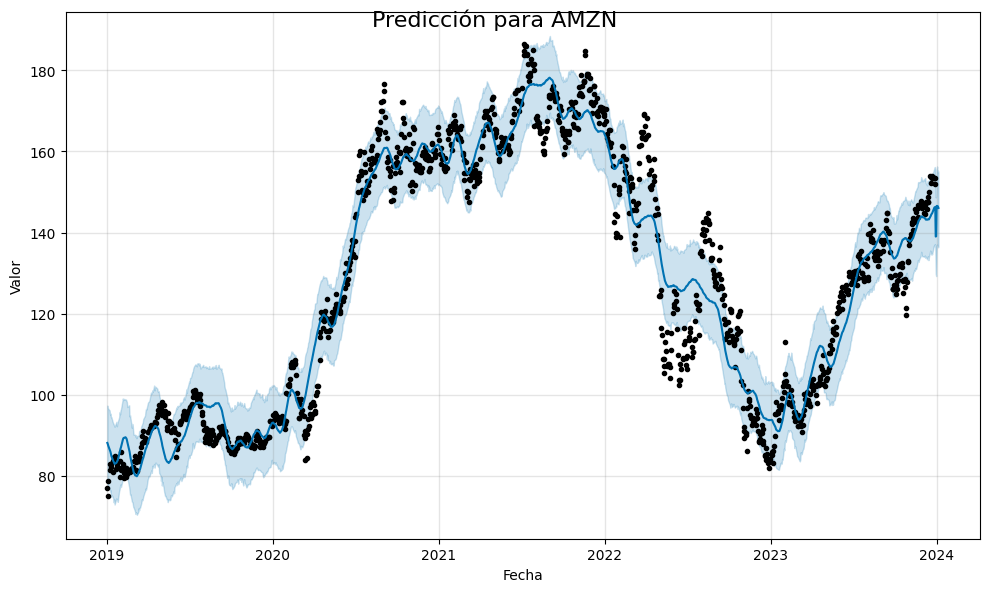

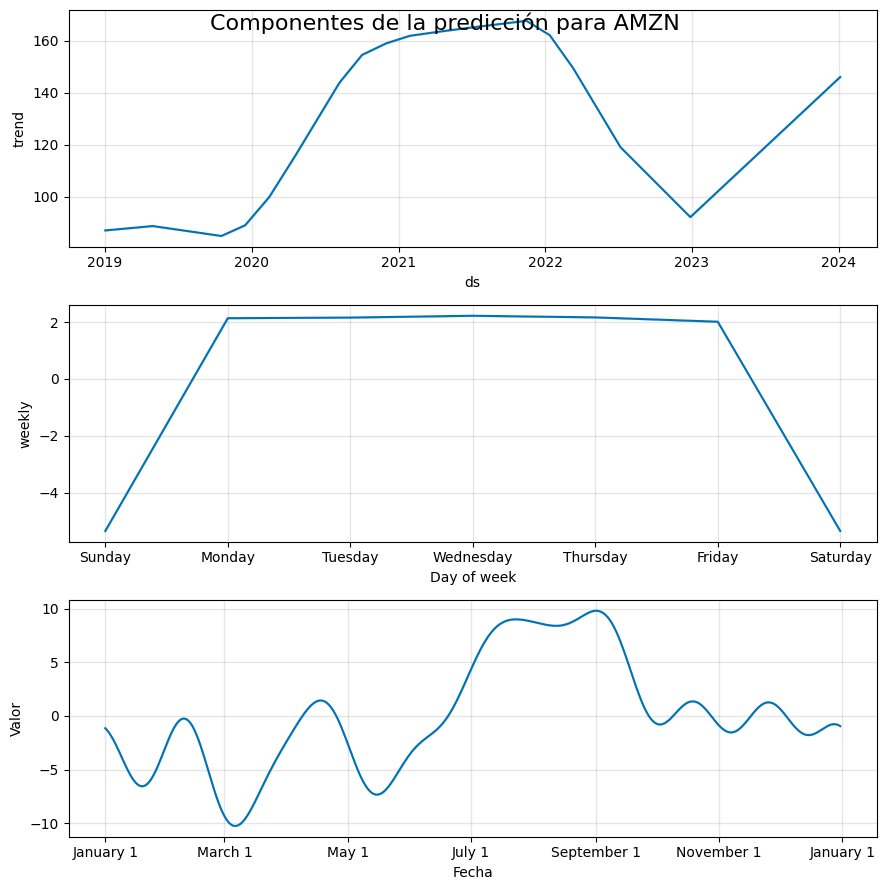

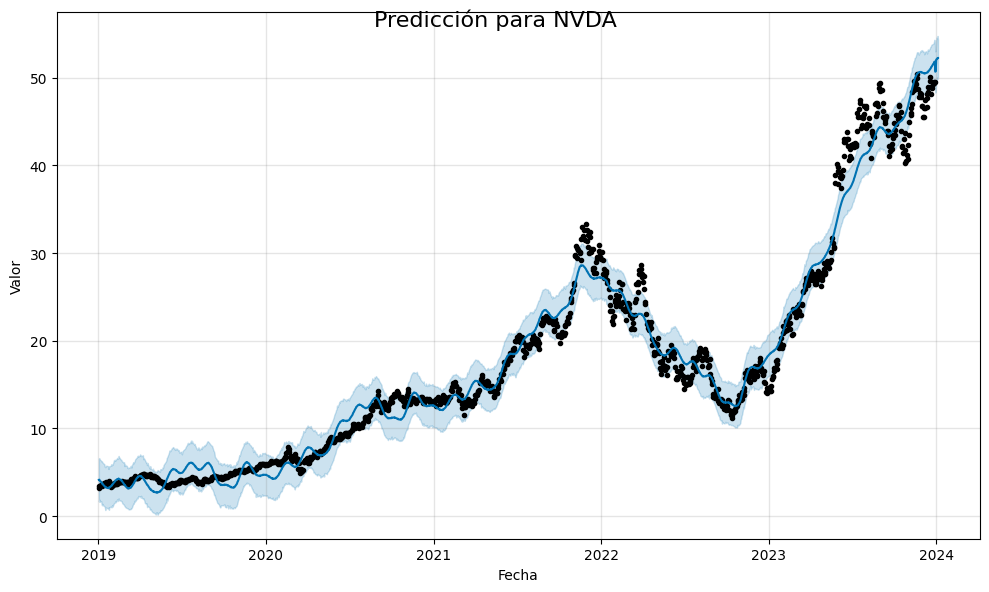

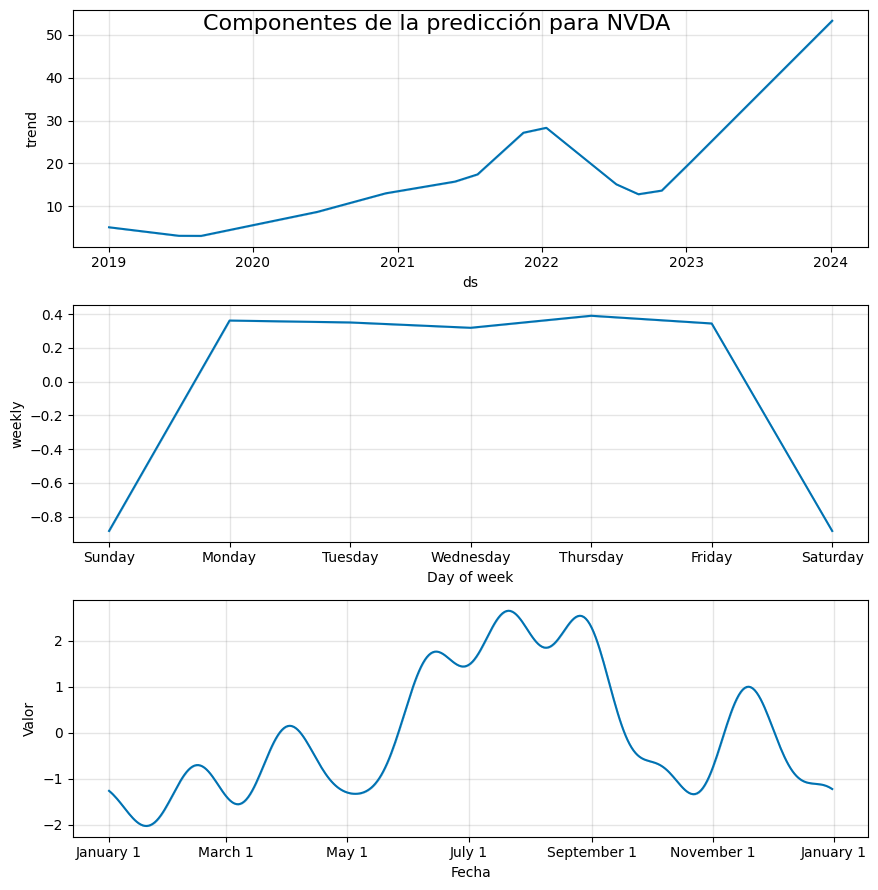

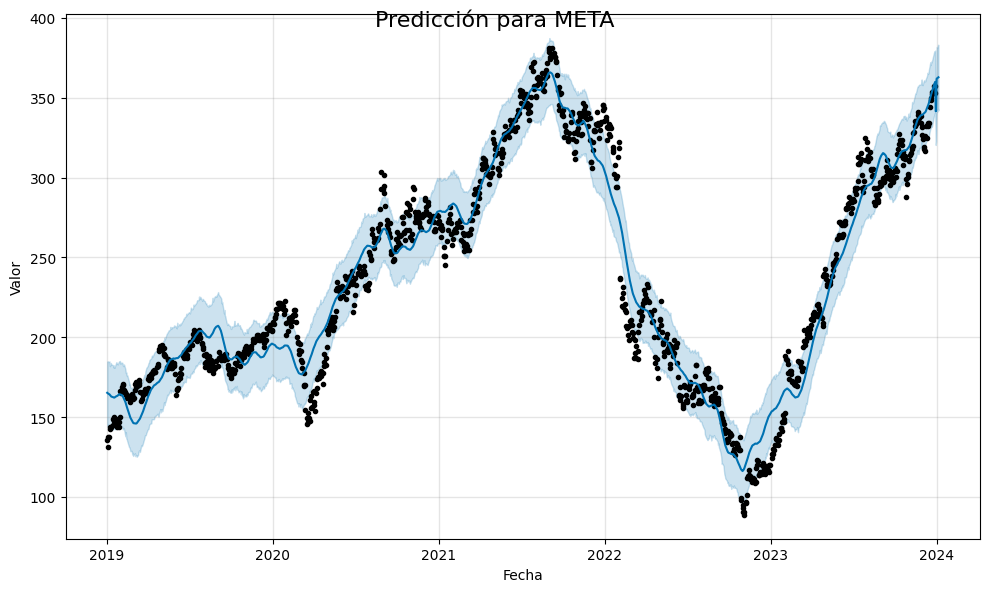

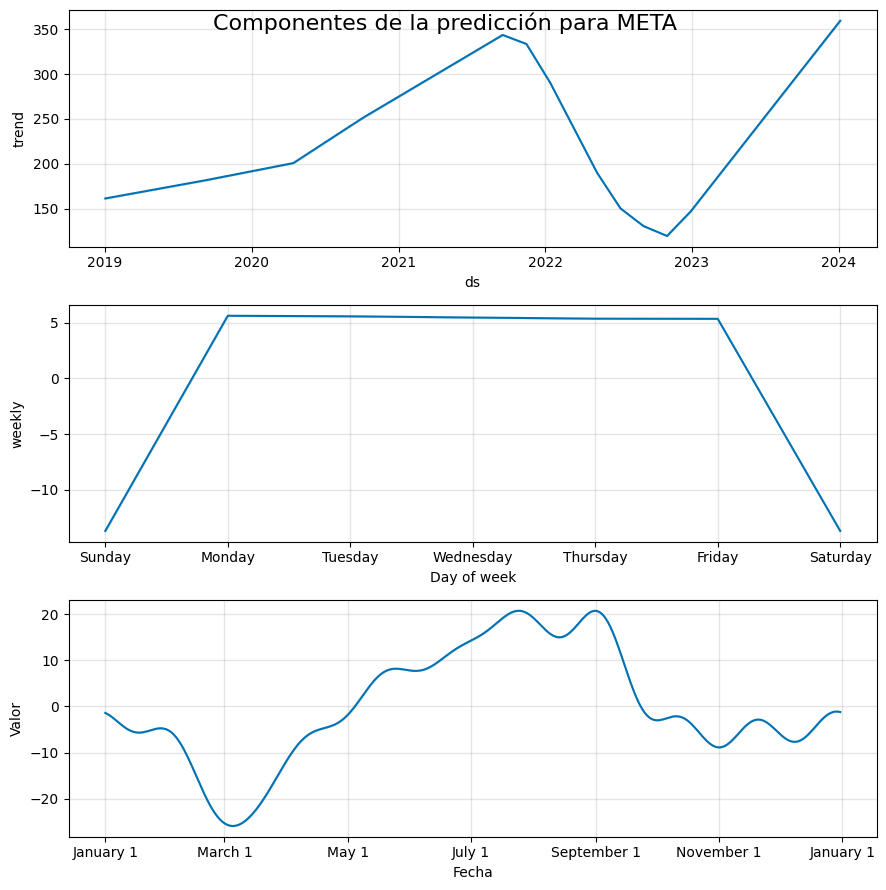

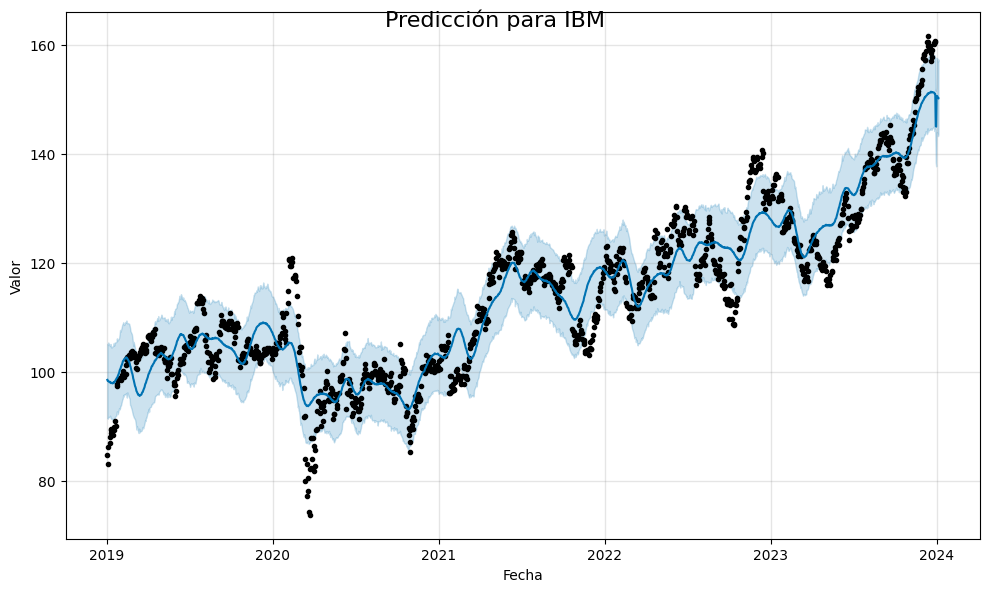

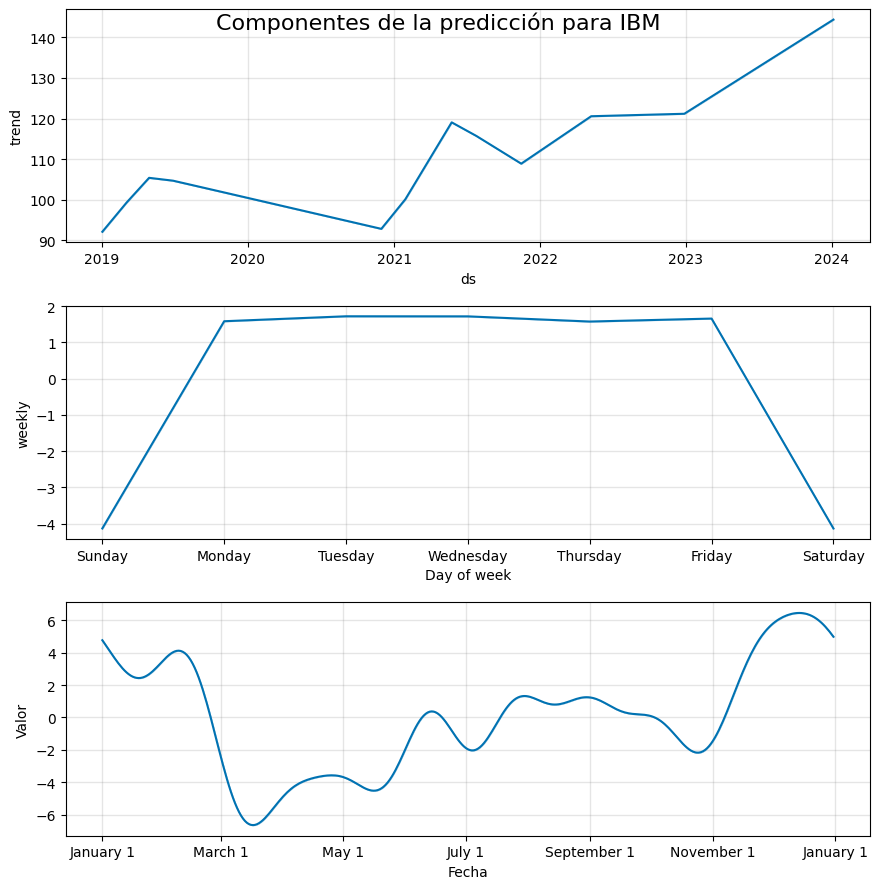

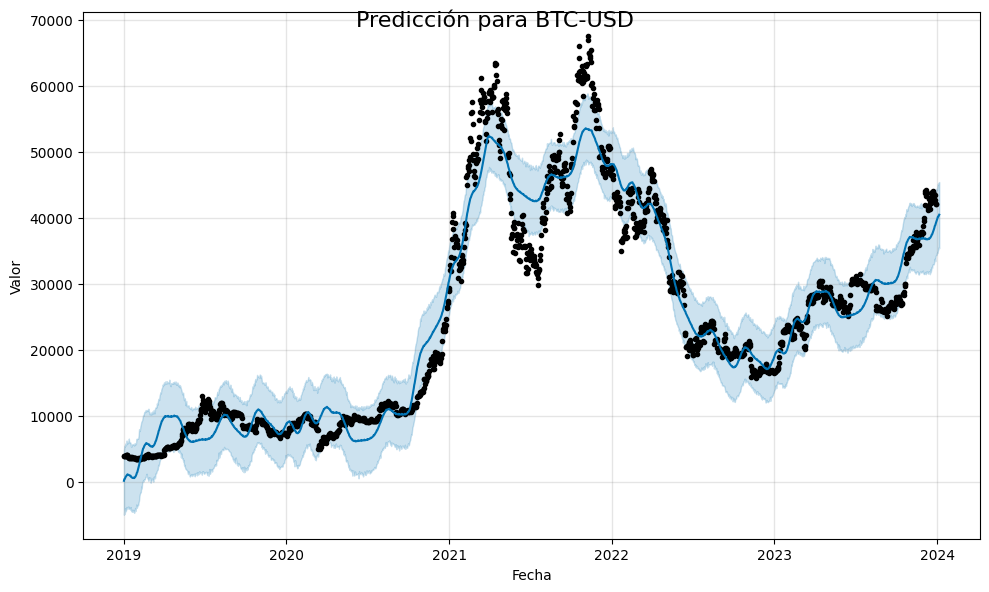

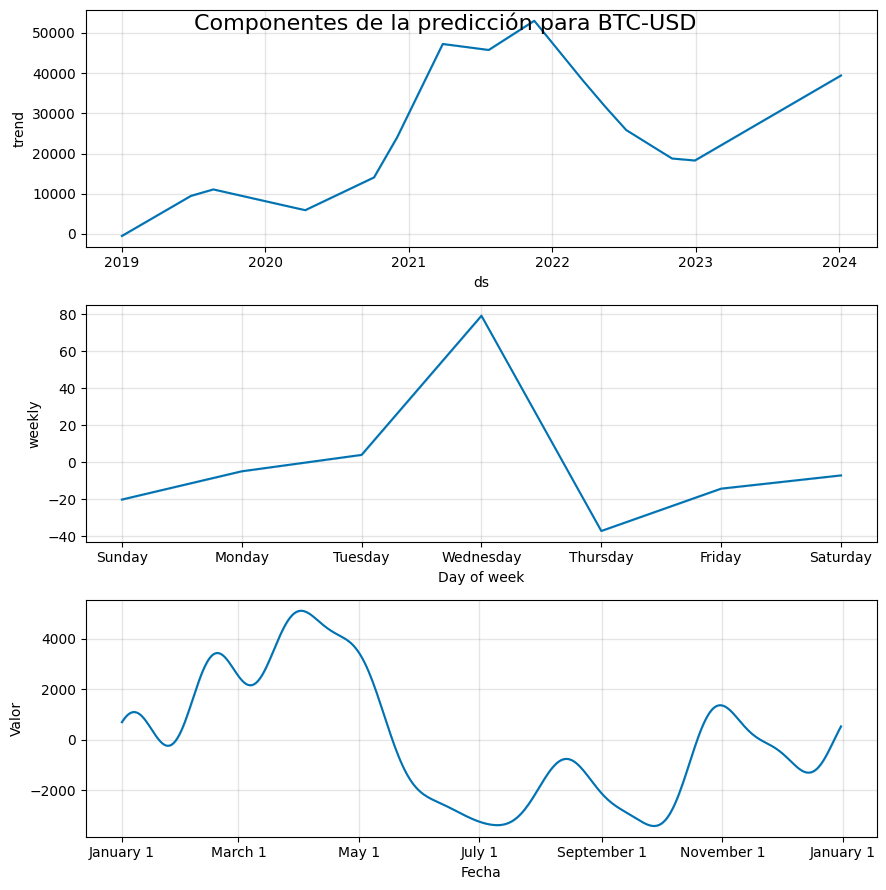

                 MAE           MSE         RMSE
AAPL        5.351213  4.887850e+01     6.991316
MSFT        7.266314  8.952670e+01     9.461855
GOOGL       3.339872  1.855327e+01     4.307350
AMZN        5.583101  5.401143e+01     7.349247
NVDA        1.400887  3.418586e+00     1.848942
META       12.599384  2.451784e+02    15.658175
IBM         4.184669  2.827131e+01     5.317077
BTC-USD  2954.697396  1.533463e+07  3915.945683


In [129]:
# Iterar sobre cada ticker, ajustar modelos Prophet y hacer predicciones
forecasts = {}
metrics = {}  # Definir el diccionario metrics

for ticker in tickers:
    # Preparar datos para el ticker actual
    df_ticker = prepare_data_for_ticker(Y_df, ticker)
    
    # Ajustar modelo Prophet para el ticker actual
    m = Prophet()
    m.fit(df_ticker)
    
    # Crear dataframe para el futuro
    future = m.make_future_dataframe(periods=7)
    
    # Realizar predicciones para el ticker actual
    forecast = m.predict(future)
    
    # Almacenar las predicciones en el diccionario forecasts
    forecasts[ticker] = forecast

    # Calcular las métricas de error utilizando los datos históricos
    y_true = df_ticker['y'].values
    y_pred = forecast['yhat'][:len(y_true)].values
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Almacenar las métricas en el diccionario metrics
    metrics[ticker] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    
    # Visualizar resultados
    fig1 = m.plot(forecast)
    fig1.suptitle(f'Predicción para {ticker}', fontsize=16)  # Título del gráfico
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.show()
    
    fig2 = m.plot_components(forecast)
    fig2.suptitle(f'Componentes de la predicción para {ticker}', fontsize=16)  # Título del gráfico
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.show()

# Mostrar las métricas de error para cada ticker
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)